# Curvature analyzer

This notebook presents how to use the [`pychemcurv.CurvatureAnalyzer`](https://pychemcurv.readthedocs.io/en/latest/analysis.html#curvatureanalyzer-class) 
class. This class aims to return data on a whole molecular or periodic system.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 20, "axes.grid": True})
import nglview as nv

import pymatgen as mg
from pychemcurv import CurvatureAnalyzer

## Molecule
---
Example on a C32 isomer. From a pymatgen Molecule object:

In [4]:
mol = mg.core.Molecule.from_file("./C32-C2-1.xyz")
ca = CurvatureAnalyzer(mol)

In [5]:
view = nv.show_pymatgen(mol)
view

NGLWidget()

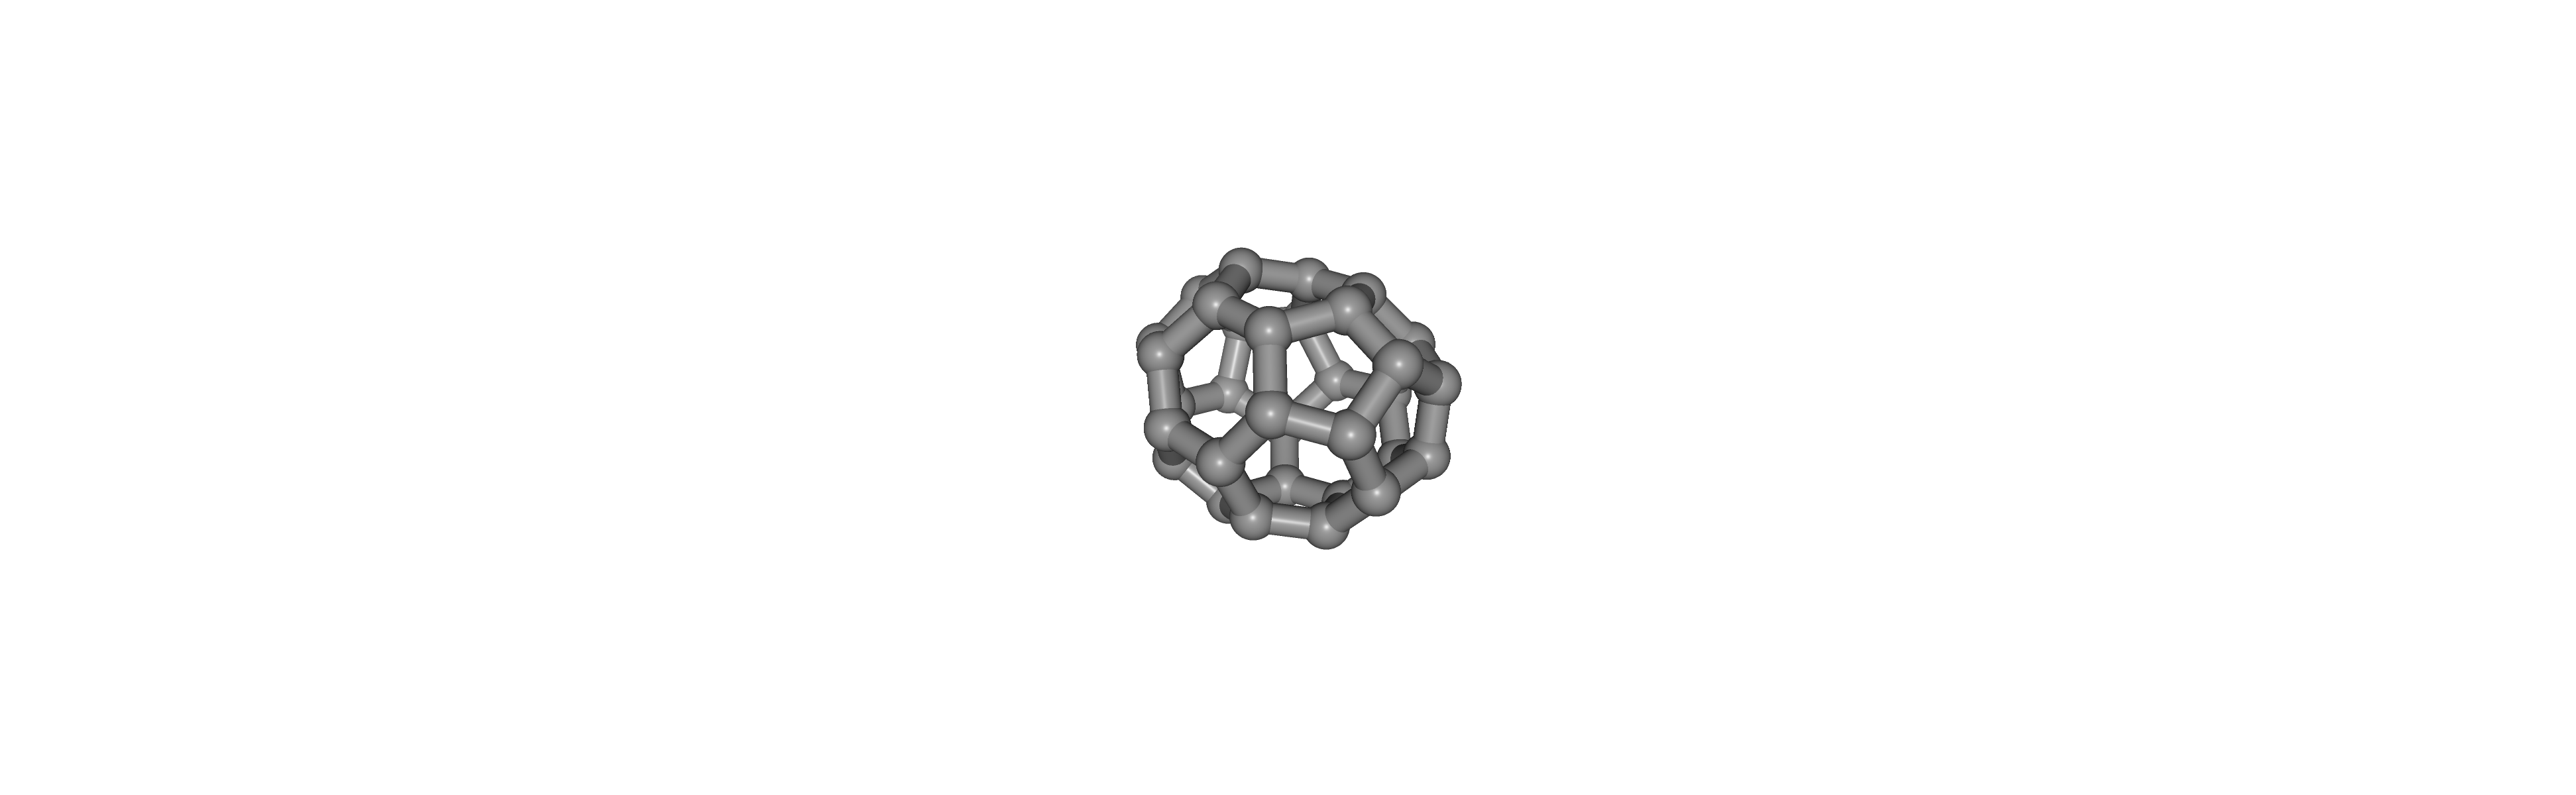

In [7]:
#view.render_image()
view._display_image()

Directly from a file:

In [8]:
ca = CurvatureAnalyzer.from_file("./C32-C2-1.xyz")

Read structure, done.


Data attribute is a pandas DataFrame.

In [9]:
ca.data.columns

Index(['hybridization', 'n', 'm', 'c_pi^2', 'lambda_pi^2', 'poav', 'atom_A',
       'star_A', 'reg_star_A', 'distances', 'angles', 'n_star_A',
       'angular_defect', 'pyr_distance', 'pyrA', 'spherical_curvature',
       'improper', 'pi_hyb_nbr', 'u_pi', 'matrix', 'n_1', 'n_2', 'n_3',
       'atom_idx', 'species', 'ave. neighb. dist.'],
      dtype='object')

In [10]:
ca.data[['pyrA', 'spherical_curvature', 'angular_defect',
       'pyr_distance', 'n_star_A', 'hybridization', 
       'c_pi^2', 'lambda_pi^2', 'atom_idx',
       'ave. neighb. dist.']].head()

,pyrA,spherical_curvature,angular_defect,pyr_distance,n_star_A,hybridization,c_pi^2,lambda_pi^2,atom_idx,ave. neighb. dist.
0,19.037993,0.454660,30.311035,0.467867,3,2.937762,0.238146,0.761854,0,1.434442
1,18.401262,0.433454,28.737243,0.459565,3,2.852833,0.221352,0.778648,1,1.456086
2,23.005967,0.538896,42.850794,0.566009,3,3.691653,0.360566,0.639434,2,1.450110
3,13.128629,0.314696,15.149612,0.327497,3,2.366234,0.108796,0.891204,3,1.445920
4,13.128629,0.314696,15.149612,0.327497,3,2.366234,0.108796,0.891204,4,1.445920


#### Plot properties

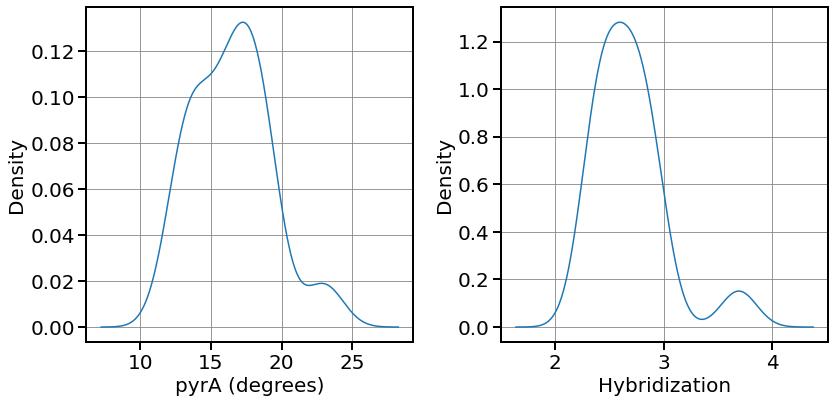

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ca.data.pyrA.plot.kde(ax=ax1)
ax1.set_xlabel("pyrA (degrees)")
ca.data.hybridization.plot.kde(ax=ax2)
ax2.set_xlabel("Hybridization")
plt.tight_layout()

<AxesSubplot:xlabel='hybridization', ylabel='pyrA'>

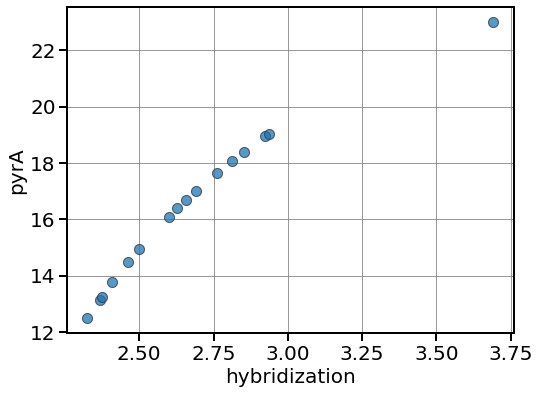

In [12]:
ca.data.plot(x="hybridization", y="pyrA", kind="scatter", s=100, 
             figsize=(8, 6), alpha=.5, edgecolor="#333333", zorder=2)

## Periodic structure
---
Example using a periodic structure. The structure below is a carbon nanotube with a constraints that make it ellipsoidal.

In [15]:
s = mg.core.Structure.from_file("5.7GPa.POSCAR.vasp")
ca = CurvatureAnalyzer(s)

In [16]:
view = nv.show_pymatgen(s)
view.add_unitcell()
#view.camera = "orthographic"
view

NGLWidget()

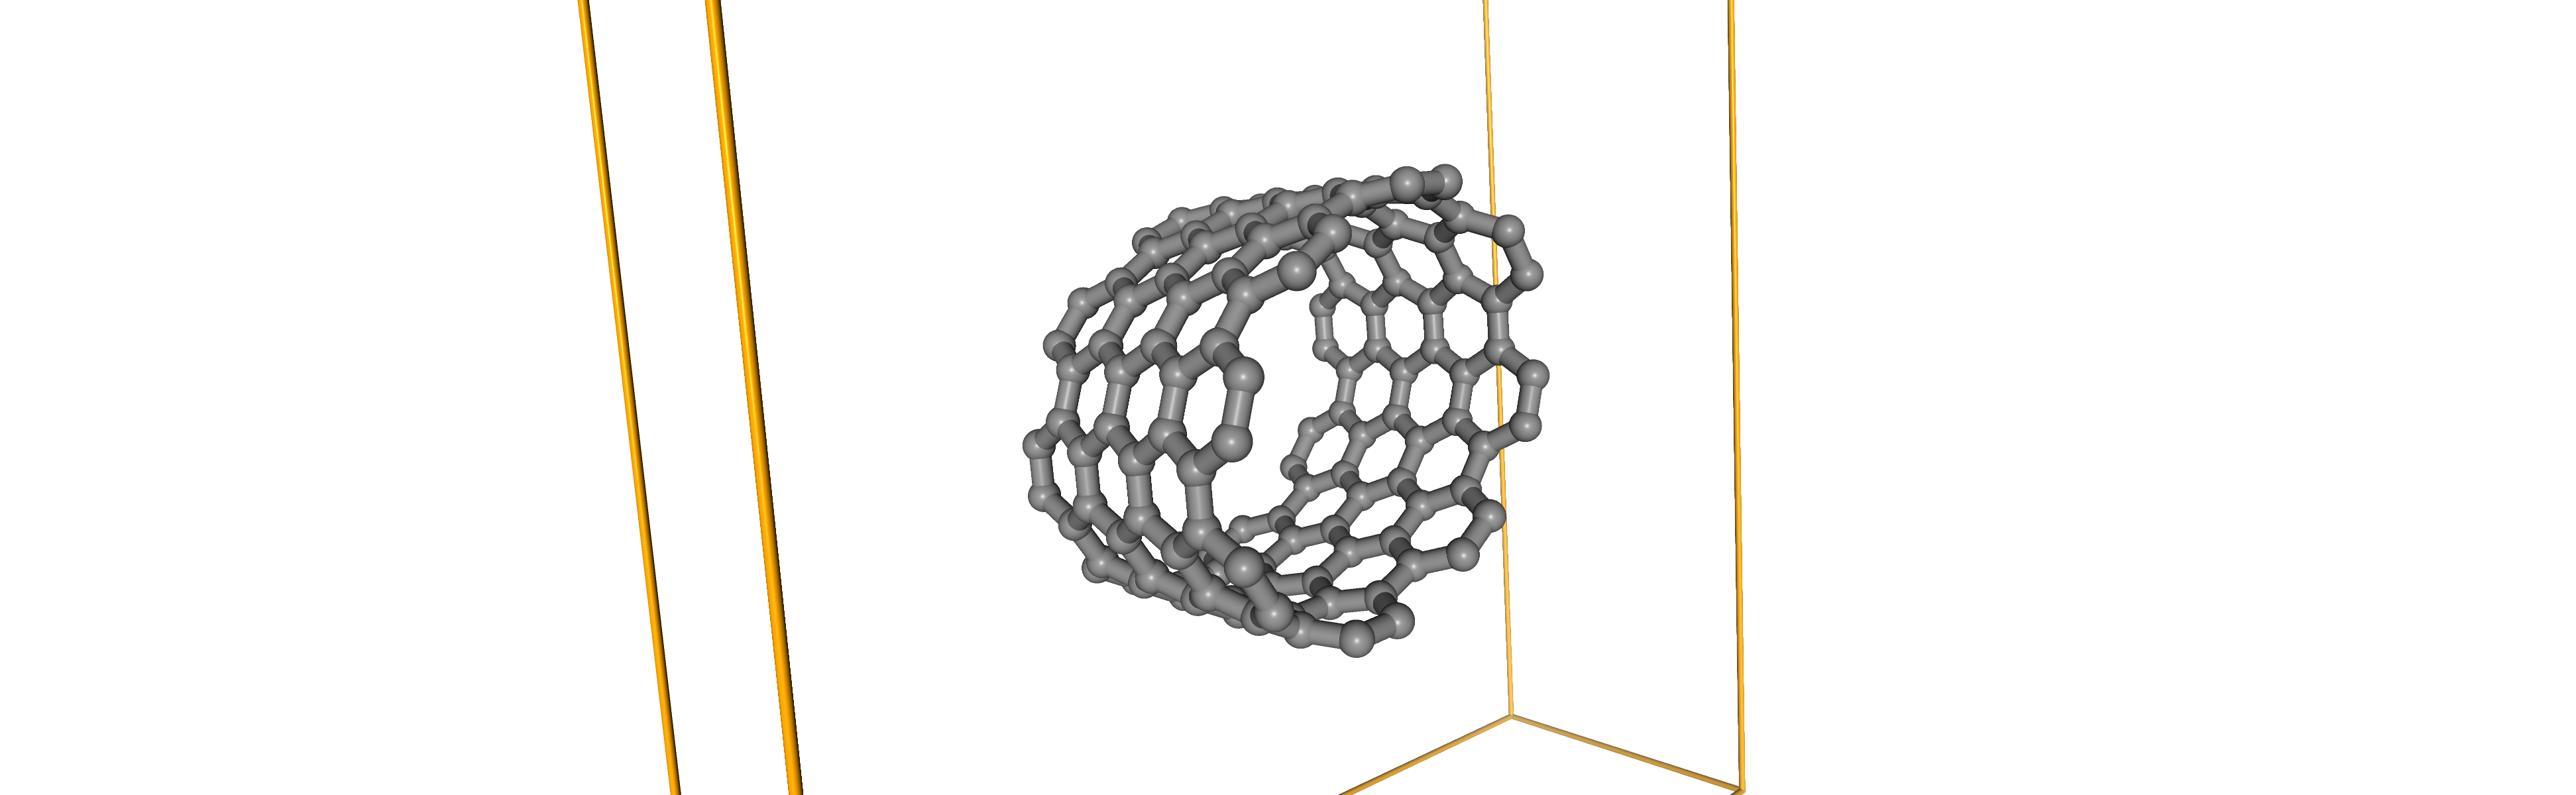

In [18]:
#view.render_image()
view._display_image()

Directly from a file:

In [19]:
ca = CurvatureAnalyzer.from_file("5.7GPa.POSCAR.vasp", periodic=True)

Read structure, done.


In [20]:
ca.data.columns

Index(['hybridization', 'n', 'm', 'c_pi^2', 'lambda_pi^2', 'poav', 'atom_A',
       'star_A', 'reg_star_A', 'distances', 'angles', 'n_star_A',
       'angular_defect', 'pyr_distance', 'pyrA', 'spherical_curvature',
       'improper', 'pi_hyb_nbr', 'u_pi', 'matrix', 'n_1', 'n_2', 'n_3',
       'atom_idx', 'species', 'ave. neighb. dist.'],
      dtype='object')

In [21]:
ca.data.iloc[:, [23, 24, 11, 14, 15, 16, 12, 13, 0, 3, 4]].head()

,atom_idx,species,n_star_A,pyrA,spherical_curvature,improper,angular_defect,pyr_distance,hybridization,c_pi^2,lambda_pi^2
0,0,C,3,5.055849,0.124138,-10.148558,2.303479,0.125124,2.047710,0.015654,0.984346
1,1,C,3,5.040057,0.123848,-10.108596,2.289201,0.124636,2.047406,0.015556,0.984444
2,2,C,3,5.055849,0.124138,10.148558,2.303479,0.125124,2.047710,0.015654,0.984346
3,3,C,3,11.420852,0.040246,10.148558,121.201008,0.125124,2.266620,0.081619,0.918381
4,4,C,3,5.040057,0.123848,-10.108596,2.289201,0.124636,2.047406,0.015556,0.984444


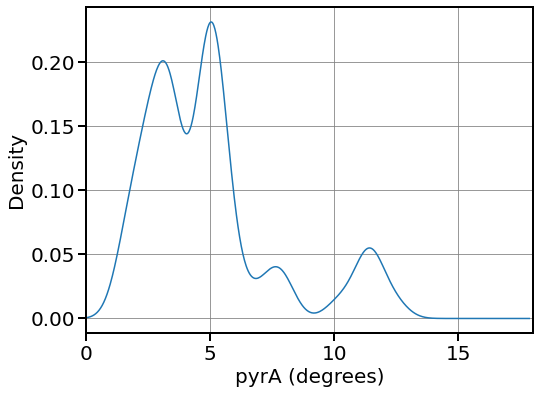

In [22]:
ax = ca.data.pyrA.plot.kde(figsize=(8, 6), xlim=(0, 18), bw_method=.2)
ax.set_xlabel("pyrA (degrees)");

Compute the distance from the axis of the nanotube and the coordinates of the atoms using cylindrical coordinates.

In [23]:
G = np.sum(ca.data.atom_A) / len(ca.data)

def get_theta(coords):
    coords -= G
    theta = np.degrees(np.arctan2(coords[2], coords[0])) + 180.
    return theta

def get_r(coords):
    coords -= G
    r = np.sqrt(coords[0]**2 + coords[2]**2)
    return r

ca.data["theta"] = ca.data.atom_A.apply(get_theta)
ca.data["r"] = ca.data.atom_A.apply(get_r)
ca.data["y"] = ca.data.atom_A.apply(lambda x: x[1])

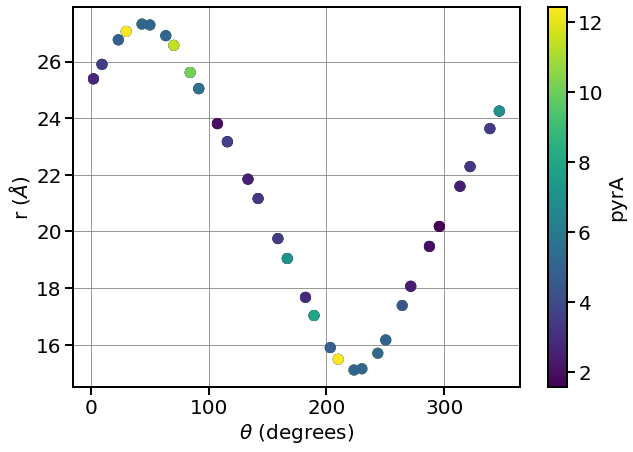

In [24]:
#ax = ca.data.plot.scatter(x="theta", s=100, y="r", figsize=(10, 7))
#
fig, ax = plt.subplots(figsize=(10, 7))
ax = ca.data.plot.scatter(x="theta", c="pyrA", s=100, y="r", cmap="viridis", 
                          ax=ax, zorder=2)
ax.set_xlabel(r"$\theta$ (degrees)")
ax.set_ylabel(r"r ($\AA$)");

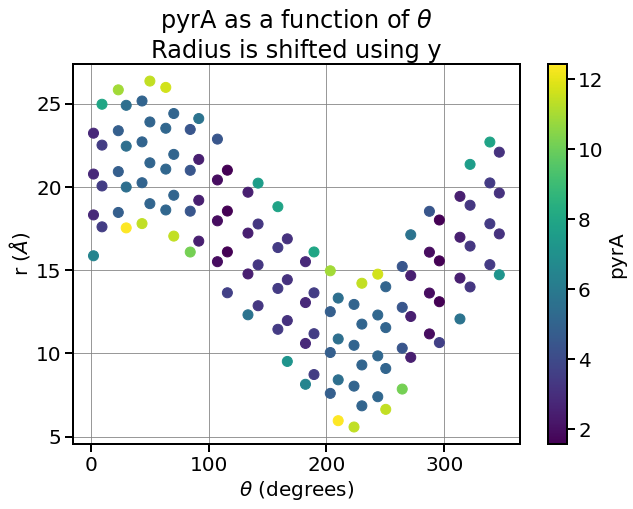

In [25]:
#ax = ca.data.plot.scatter(x="theta", s=100, y="r", figsize=(10, 7))
#
fig, ax = plt.subplots(figsize=(10, 7))
ca.data["r+y"] = ca.data.r + ca.data.y
ax = ca.data.plot.scatter(x="theta", c="pyrA", s=100, y="r+y", cmap="viridis", 
                          ax=ax, zorder=2)
ax.set_xlabel(r"$\theta$ (degrees)")
ax.set_ylabel(r"r ($\AA$)")
ax.set_title(r"pyrA as a function of $\theta$" + "\nRadius is shifted using y");